In [15]:
# INITIALIZE CUSTOM HELPER CLASS AND SPACY
# runtime = ~3s
import spacy
nlp = spacy.load("en_core_web_lg")

%reload_ext autoreload
%autoreload 2
from classes.data_prepper import DataPrepper

p = DataPrepper()

constructor of DataPrepper


In [16]:
# LOAD CLASS AND DATASET 
# dataset: https://www.kaggle.com/rmisra/news-category-dataset
# start:    each doc in corpus contains an article link, category and other (irrelevant) key/value pairs
# end goal: each doc in corpus contains a sentece #, word, lemma, POS-tag, gender and polarity
# runtime = ~2s

data = p.load_json('../datasets/1_newsDataset.json')

In [17]:
# FILTER CATEGORIES
# runtime = ~1s
men_categories = ['SPORTS', 'MONEY', 'BUSINESS']
women_categories = ['WOMEN', 'STYLE & BEAUTY']

data['articles'] = p.filter_articles(men_categories+women_categories, data['articles'])

p.write_json('../datasets/2_filtered_category.json', data)

In [25]:
# SCRAPE LINKS
data = p.load_json('../datasets/2_filtered_category.json')

scraped_data = {}
scraped_data['articles'] = []
textlessUrls = []

for article in data['articles']:
    text = p.scrape_url(article['link'], textlessUrls)
    gender = 'M' if article['category'] in men_categories else 'F'
    if text != "":
        scraped_data['articles'].append({'gender': gender, 'text': text})

p.write_json('../datasets/3_text_and_gender.json', scraped_data)

In [18]:
# SPLITTING TRAINING AND TEST DATA
# runtime = ~3s
data = p.load_json('../datasets/3_text_and_gender.json')

split = round(len(data['articles'])*0.75)

training_data = data['articles'][:split]
test_data = data['articles'][split:]

p.write_json('../datasets/4_text_and_gender_training.json', training_data)
p.write_json('../datasets/4_text_and_gender_test.json', test_data)

In [24]:
# CALCULATE WEIGHTS FOR EACH TERM
# using tf-idf weighting from 'An Introduction to Information Retrieval (2009 Online Edition)'
# written by Christopher D. Manning, Prabhakar Raghavan & Hinrich Schütze
# runtime = ~23m
import itertools

data = p.load_json('../datasets/4_text_and_gender_training.json')

ignore_terms = ['.', ',', '...', ' ', '\u2019', '  ', '(', ')', '?', '\u00a3', '/', '"', ':', ';', '-', '--', '\u2015', "'", '!', '$', '#', '\u2014', '   ', '[',']']
ignore_ents = ['TIME', 'DATE', 'GPE', 'CARDINAL', 'PERSON', 'MONEY', 'PERCENT']

m_weights, w_weights = p.get_weights(data, nlp, ignore_terms, ignore_ents)
m_weights = p.order_dict(m_weights, 'desc')
w_weights = p.order_dict(w_weights, 'desc')
p.write_json('../datasets/5_BEFORE_SLICE_word_weight_m.json', m_weights)
p.write_json('../datasets/5_BEFORE_SLICE_word_weight_f.json', w_weights)

m_weights = {k:v for k,v in m_weights.items() if v >= 0.05}
w_weights = {k:v for k,v in w_weights.items() if v >= 0.05}

m_weights = p.order_dict(m_weights, 'desc')
w_weights = p.order_dict(w_weights, 'desc')

print('len of m_weights is', len(m_weights), 'and w_weights is', len(w_weights), '\nTo level the numbers to prevent bias, the two dicts are sliced. Dismissing the most neutral terms.')
slice = 1500
m_weights = dict(itertools.islice(m_weights.items(), slice))
w_weights = dict(itertools.islice(w_weights.items(), slice))

p.write_json('../datasets/5_word_weight_m.json', m_weights)
p.write_json('../datasets/5_word_weight_f.json', w_weights)

len of m_weights is 2260 and w_weights is 1505 
To level the numbers to prevent bias, the two dicts are sliced. Dismissing the most neutral terms.


In [ ]:
# STANDARDINALIZE WEIGHTS
from sklearn.preprocessing import StandardScaler
import numpy as np 

m_weights = p.load_json('../datasets/4_word_weight_m.json')
s = StandardScaler()
m_values = list(m_weights.values())
m_values = np.array(m_values)
m_values = m_values.reshape(-1,1)
s.fit(m_values)
m_values = s.transform(m_values)

for i, (k, v) in enumerate(m_weights.items()):
    m_weights[k] = float(m_values[i])

w_weights = p.load_json('../datasets/4_word_weight_w.json')
s = StandardScaler()
w_values = list(w_weights.values())
w_values = np.array(w_values)
w_values = w_values.reshape(-1,1)
s.fit(w_values)
w_values = s.transform(w_values)

for i, (k, v) in enumerate(w_weights.items()):
    w_weights[k] = float(w_values[i])

p.write_json('../datasets/5_word_weight_m_standard.json', m_weights)
p.write_json('../datasets/5_word_weight_w_standard.json', w_weights)

polarity_dict = p.get_polarity(w_weights, m_weights)
polarity_dict = p.order_dict(polarity_dict, 'desc')

p.write_json('../datasets/6_polarity_dict_standard.json', polarity_dict)

In [19]:
# NORMALIZE WEIGHTS
# runtime = ~1s
m_weights = p.load_json('../datasets/5_word_weight_m.json')
w_weights = p.load_json('../datasets/5_word_weight_f.json')

p.normalize_dict(m_weights)
p.normalize_dict(w_weights)

m_weights = p.order_dict(m_weights, 'desc')
w_weights = p.order_dict(w_weights, 'desc')

p.write_json('../datasets/5_word_weight_m_norm.json', m_weights)
p.write_json('../datasets/5_word_weight_f_norm.json', w_weights)

In [20]:
# CALCULATE POLARITY FOR EACH TERM
# -1 (masculine) to 1 (feminine)
# runtime = ~2s

m_weights = p.load_json('../datasets/5_word_weight_m_norm.json')
w_weights = p.load_json('../datasets/5_word_weight_f_norm.json')

polarity_dict = p.get_polarity(w_weights, m_weights)
polarity_dict = p.order_dict(polarity_dict, 'desc')

p.write_json('../datasets/6_polarity_dict_norm.json', polarity_dict)

No handles with labels found to put in legend.


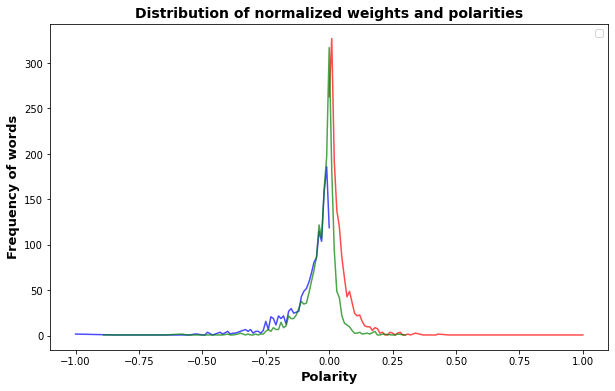

In [21]:
# VISUALIZE NORMALIZED WEIGHTS AND POLARITY DISTRIBUTION
import numpy as np 
import matplotlib.pyplot as plt

m_weights = p.load_json('../datasets/5_word_weight_m_norm.json')
w_weights = p.load_json('../datasets/5_word_weight_f_norm.json')
pols = p.load_json('../datasets/6_polarity_dict_norm.json')
m_weights = list(m_weights.values())
w_weights = list(w_weights.values())
pols = list(pols.values())

m_weights_rounded = []
for weight in m_weights:
    m_weights_rounded.append(round(float(-1*weight), 2))
x, y = np.unique(m_weights_rounded, return_counts=True)


plt.figure(figsize=[10,6])
plt.plot(x, y, color='b', alpha=0.7)


w_weights_rounded = []
for weight in w_weights:
    w_weights_rounded.append(round(float(weight), 2))
x, y = np.unique(w_weights_rounded, return_counts=True)

plt.plot(x, y, color='r', alpha=0.7)


pols_rounded = []
for weight in pols:
    pols_rounded.append(round(float(weight), 2))
x, y = np.unique(pols_rounded, return_counts=True)

plt.plot(x, y, color='g', alpha=0.7)


ax2 = plt.gca()

plt.ylabel('Frequency of words', fontdict={'fontsize':13, 'fontweight': 'bold'})
plt.xlabel('Polarity', fontdict={'fontsize':13, 'fontweight': 'bold'})
plt.title("Distribution of normalized weights and polarities", fontdict={'fontsize':14, 'fontweight': 'bold'})
plt.legend()
plt.show()

In [ ]:
# VISUALIZE STANDARDALIZED WEIGHTS AND POLARITY DISTRIBUTION
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

m_weights = p.load_json('../datasets/5_word_weight_m_standard.json')
w_weights = p.load_json('../datasets/5_word_weight_w_standard.json')
pols = p.load_json('../datasets/6_polarity_dict_standard.json')
m_weights = list(m_weights.values())
w_weights = list(w_weights.values())
pols = list(pols.values())
# m_weights = np.array(m_weights)
pol_to_rep = {
  -1.0: 0,
  -0.9: 1,
  -0.8: 2,
  -0.7: 3,
  -0.6: 4,
  -0.5: 5,
  -0.4: 6,
  -0.3: 7,
  -0.2: 8,
  -0.1: 9,
  -0.0: 10,
  0.0: 10,
  0.1: 11,
  0.2: 12,
  0.3: 13,
  0.4: 14,
  0.5: 15,
  0.6: 16,
  0.7: 17,
  0.8: 18,
  0.9: 19,
  1.0: 20,
}

m_weights_rounded = []
for weight in m_weights:
    m_weights_rounded.append(round(float(weight), 2))
# m_weights_rounded = m_weights_rounded[:5000]
x, y = np.unique(m_weights_rounded, return_counts=True)


plt.figure(figsize=[10,6])
# plt.bar(x, y, color='b', width=0.1, alpha=0.7, align='center')
plt.plot(x, y, color='b', alpha=0.7)


w_weights_rounded = []
for weight in w_weights:
    w_weights_rounded.append(round(float(weight), 2))
# w_weights_rounded = w_weights_rounded[:5000]
x, y = np.unique(w_weights_rounded, return_counts=True)

# plt.bar(x, y, color='r', width=0.1, alpha=0.7, align='center')

plt.plot(x, y, color='r', alpha=0.7)


pols_rounded = []
for weight in pols:
    pols_rounded.append(round(float(weight), 2))
# pols_rounded = pols_rounded[:5000]
x, y = np.unique(pols_rounded, return_counts=True)

# plt.bar(x, y, color='r', width=0.1, alpha=0.7, align='center')

plt.plot(x, y, color='g', alpha=0.7)


ax2 = plt.gca()

plt.ylabel('Frequency of words', fontdict={'fontsize':13, 'fontweight': 'bold'})
plt.xlabel('Polarity', fontdict={'fontsize':13, 'fontweight': 'bold'})
plt.title("Distribution of standardized weights and polarities", fontdict={'fontsize':14, 'fontweight': 'bold'})
plt.legend()
plt.show()

In [ ]:
# WRAP ALL INTO FINAL DATASET
# split all texts into sentences into words, each assigned sentence #, word, lemma, pos and polarity
# runtime: ~102 min

data = p.load_json('../datasets/3_text_and_gender.json')
polarity_dict = p.load_json('../datasets/6_polarity_dict_norm.json')

# Sentiment corpus
corpus =    {
                'Sentence #': [], 
                'Word': [],
                'Lemma': [],
                'POS': [],
                'Polarity': [],
                'Gender': []
            }

# a corpus just containing sentences numbers and text for simplicity
sentences =    {
                'Sentence #': [], 
                'Text': []
            }

sentenceCount = 1

ignore_terms = ['.', ',', '...', ' ', '\u2019', '  ', '(', ')', '?', '\u00a3', '/', '"', ':', ';', '-', '--', '\u2015', "'", '!', '$', '#', '\u2014', '   ', '[',']']
ignore_ents = ['TIME', 'DATE', 'GPE', 'CARDINAL', 'PERSON', 'MONEY', 'PERCENT']

for article in data['articles']:
    doc = nlp(article['text'])
    for sent in doc.sents:
        preproccesed_sentence = p.preprocess_text(sent.text)
        sentence = nlp(preproccesed_sentence)
        for token in sentence:
            if not token.is_stop and token.lemma_ not in ignore_terms and token.ent_type_ not in ignore_ents:
                corpus['Sentence #'].append(sentenceCount)
                corpus['Word'].append(token.text)
                corpus['Lemma'].append(token.lemma_)
                corpus['POS'].append(token.pos_)
                corpus['Polarity'].append(polarity_dict[token.lemma_] if token.lemma_ in polarity_dict else 0)
                corpus['Gender'].append(article['gender'])
        
        sentences['Sentence #'].append(sentenceCount)
        sentences['Text'].append(sent.text)
        sentenceCount += 1

p.write_json('../datasets/7_sentences.json', sentences)
p.write_json('../datasets/sentiment_corpus.json', corpus)

In [ ]:
# FINAL WRAP-UP TEST ON ONLY THE FIRST TEXT
# runtime: ~1 second

data = p.load_json('../datasets/3_text_and_gender.json')
polarity_dict = p.load_json('../datasets/6_polarity_dict_norm.json')

article = data['articles'][0]

# Sentiment corpus
corpus =    {
                'Sentence #': [], 
                'Word': [],
                'Lemma': [],
                'POS': [],
                'Polarity': [],
                'Gender': []
            }

# a corpus just containing sentences numbers and text for simplicity, and to see the preprocessed sentences
sentences =    {
                'Sentence #': [], 
                'Text': []
            }

sentenceCount = 1

ignore_terms = ['.', ',', '...', ' ', '\u2019', '  ', '(', ')', '?', '\u00a3', '/', '"', ':', ';', '-', '--', '\u2015', "'", '!', '$', '#', '\u2014', '   ', '[',']']
ignore_ents = ['TIME', 'DATE', 'GPE', 'CARDINAL', 'PERSON', 'MONEY', 'PERCENT']


doc = nlp(article['text'])
for sent in doc.sents:
        preproccesed_sentence = p.preprocess_text(sent.text)
        sentence = nlp(preproccesed_sentence)
        for token in sentence:
            if not token.is_stop and token.lemma_ not in ignore_terms and token.ent_type_ not in ignore_ents:
                corpus['Sentence #'].append(sentenceCount)
                corpus['Word'].append(token.text)
                corpus['Lemma'].append(token.lemma_)
                corpus['POS'].append(token.pos_)
                corpus['Polarity'].append(polarity_dict[token.lemma_] if token.lemma_ in polarity_dict else 0)
                corpus['Gender'].append(article['gender'])
        
        sentences['Sentence #'].append(sentenceCount)
        sentences['Text'].append(sent.text)
        sentenceCount += 1

print(pd.DataFrame(sentences).head(2))

import pandas as pd
pd.DataFrame(corpus).groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity'].agg(lambda x: list(x))